# Swin Transformer -- Sachin

In [1]:
#### Importing Required Libraries

# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
Copyright (C) 2019 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
# Install PyTorch
!conda install pytorch==1.12.0 torchvision==0.13.0 torchaudio==0.12.0 cudatoolkit=11.3 -c pytorch
# Install mim
!pip install -U openmim
# Install mmengine
!mim install mmengine
# Install MMCV
!mim install 'mmcv >= 2.0.0rc1'

/bin/bash: conda: command not found
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 kB 1.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu118/torch2.0.0/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 372.1/372.1 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.9/200.9 kB 26.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu118/torch2.0.0/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.4/74.4 MB 8.5 MB/s eta 0:00:00


In [3]:
#installing mmsegmentation library
!rm -rf mmsegmentation
!git clone -b main https://github.com/open-mmlab/mmsegmentation.git 
%cd mmsegmentation
!pip install -e .

Cloning into 'mmsegmentation'...
remote: Enumerating objects: 14797, done.
remote: Counting objects: 100% (384/384), done.
remote: Compressing objects: 100% (293/293), done.
remote: Total 14797 (delta 133), reused 218 (delta 84), pack-reused 14413
Receiving objects: 100% (14797/14797), 20.13 MiB | 33.91 MiB/s, done.
Resolving deltas: 100% (10436/10436), done.
/content/mmsegmentation
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/mmsegmentation
  Preparing metadata (setup.py) ... done
  Running setup.py develop for mmsegmentation


In [4]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
print(mmseg.__version__)

2.0.0+cu118 True
1.0.0


# Our dataset

In [5]:
# download and unzip
!wget http://dags.stanford.edu/data/iccv09Data.tar.gz -O stanford_background.tar.gz
!tar xf stanford_background.tar.gz

--2023-04-29 18:25:33--  http://dags.stanford.edu/data/iccv09Data.tar.gz
Resolving dags.stanford.edu (dags.stanford.edu)... 171.64.68.10
Connecting to dags.stanford.edu (dags.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14727974 (14M) [application/x-gzip]
Saving to: ‘stanford_background.tar.gz’

stanford_background 100%[===================>]  14.04M  12.7MB/s    in 1.1s    

2023-04-29 18:25:34 (12.7 MB/s) - ‘stanford_background.tar.gz’ saved [14727974/14727974]



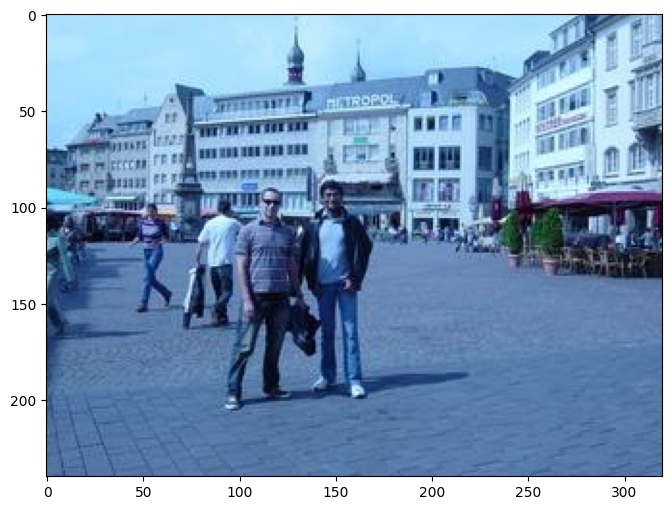

In [6]:
# sample of data from dataset
import mmcv
import mmengine
import matplotlib.pyplot as plt


img = mmcv.imread('iccv09Data/images/0000047.jpg')
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

We need to convert the annotation into semantic map format as an image.

In [7]:
# define dataset root and directory for images and annotations
data_root = 'iccv09Data'
img_dir = 'images'
ann_dir = 'labels'
# define class and palette
classes = ('sky', 'tree', 'road', 'grass', 'water', 'bldg', 'mntn', 'fg obj')
palette = [[128, 128, 128], [129, 127, 38], [120, 69, 125], [53, 125, 34], 
           [0, 11, 123], [118, 20, 12], [122, 81, 25], [241, 134, 51]]

In [8]:
import os.path as osp
import numpy as np
from PIL import Image

# convert dataset annotation to semantic segmentation map
for file in mmengine.scandir(osp.join(data_root, ann_dir), suffix='.regions.txt'):
  seg_map = np.loadtxt(osp.join(data_root, ann_dir, file)).astype(np.uint8)
  seg_img = Image.fromarray(seg_map).convert('P')
  seg_img.putpalette(np.array(palette, dtype=np.uint8))
  seg_img.save(osp.join(data_root, ann_dir, file.replace('.regions.txt', 
                                                         '.png')))

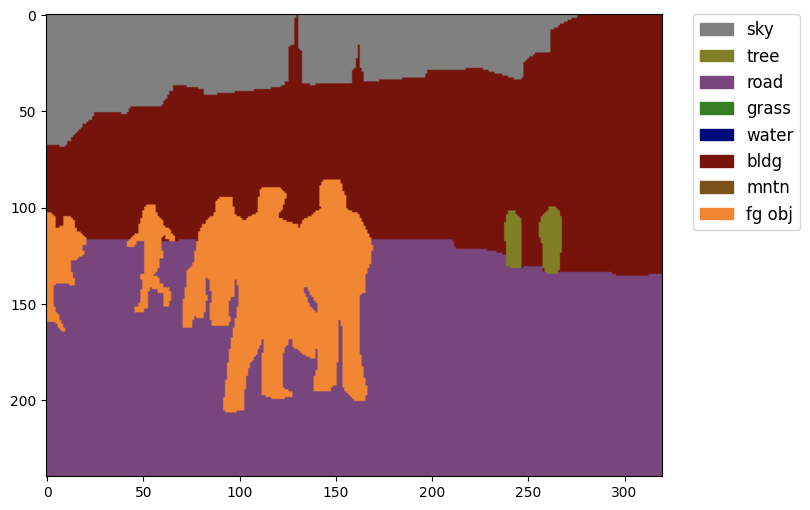

In [9]:
# vizualizing the sematic map
import matplotlib.patches as mpatches
img = Image.open('iccv09Data/labels/0000047.png')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img.convert('RGB')))

# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(8)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()

In [10]:
split_dir = 'splits'
mmengine.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmengine.scandir(
    osp.join(data_root, ann_dir), suffix='.png')]
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
  # select first 4/5 as train set
  train_length = int(len(filename_list)*4/5)
  f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
  # select last 1/5 as train set
  f.writelines(line + '\n' for line in filename_list[train_length:])

In [11]:
# Genrating Dataset  
from mmseg.registry import DATASETS
from mmseg.datasets import BaseSegDataset


@DATASETS.register_module()
class StanfordBackgroundDataset(BaseSegDataset):
  METAINFO = dict(classes = classes, palette = palette)
  def __init__(self, **kwargs):
    super().__init__(img_suffix='.jpg', seg_map_suffix='.png', **kwargs)
    

### Create a config file
In the next step, we need to modify the config for the training. To accelerate the process, we finetune the model from trained weights.

In [12]:
# Download config and checkpoint files
!mim download mmsegmentation --config swin-base-patch4-window7-in1k-pre_upernet_8xb2-160k_ade20k-512x512 --dest .

processing swin-base-patch4-window7-in1k-pre_upernet_8xb2-160k_ade20k-512x512...
downloading ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 463.3/463.3 MiB 15.0 MB/s eta 0:00:00
Successfully downloaded upernet_swin_base_patch4_window7_512x512_160k_ade20k_pretrain_224x224_1K_20210526_192340-593b0e13.pth to /content/mmsegmentation
Successfully dumped swin-base-patch4-window7-in1k-pre_upernet_8xb2-160k_ade20k-512x512.py to /content/mmsegmentation


In [13]:
#previous config file
from mmengine import Config
cfg = Config.fromfile('configs/swin/swin-base-patch4-window7-in1k-pre_upernet_8xb2-160k_ade20k-512x512.py')
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='SyncBN', requires_grad=True)
backbone_norm_cfg = dict(type='LN', requires_grad=True)
data_preprocessor = dict(
    type='SegDataPreProcessor',
    mean=[123.675, 116.28, 103.53],
    std=[58.395, 57.12, 57.375],
    bgr_to_rgb=True,
    pad_val=0,
    seg_pad_val=255,
    size=(512, 512))
model = dict(
    type='EncoderDecoder',
    data_preprocessor=dict(
        type='SegDataPreProcessor',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        bgr_to_rgb=True,
        pad_val=0,
        seg_pad_val=255,
        size=(512, 512)),
    pretrained=None,
    backbone=dict(
        type='SwinTransformer',
        pretrain_img_size=224,
        embed_dims=128,
        patch_size=4,
        window_size=7,
        mlp_ratio=4,
        depths=[2, 2, 18, 2],
        num_heads=[4, 8, 16, 32],
        strides=(4, 2, 2, 2),
        out_indices=(0, 1, 2, 3),
        qkv_bias=True,
        qk_scale=None,
        patch_norm=True,
        dro

In [14]:
print(cfg.model.data_preprocessor.size)
print(cfg.model.backbone.norm_cfg)
print(cfg.model.decode_head.norm_cfg)
print(cfg.model.auxiliary_head.norm_cfg)

(512, 512)
{'type': 'LN', 'requires_grad': True}
{'type': 'SyncBN', 'requires_grad': True}
{'type': 'SyncBN', 'requires_grad': True}


In [15]:
print(cfg.backbone_norm_cfg)

{'type': 'LN', 'requires_grad': True}


In [16]:
# Since we use only one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
# cfg.data_preprocessor.crop_size = (256,256)
cfg.crop_size = (256, 256) # for stanford dataset
# cfg.crop_size = (512, 512)
cfg.model.data_preprocessor.size = cfg.crop_size
# cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# cfg.backbone_norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 8
cfg.model.auxiliary_head.num_classes = 8

# Modify dataset type and path
cfg.dataset_type = 'StanfordBackgroundDataset'
cfg.data_root = data_root

cfg.train_dataloader.batch_size = 4

cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='RandomResize', scale=(320, 240), ratio_range=(0.5, 2.0), keep_ratio=True),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='PackSegInputs')
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='Resize', scale=(320, 240), keep_ratio=True),
    # add loading annotation after ``Resize`` because ground truth
    # does not need to do resize data transform
    dict(type='LoadAnnotations'),
    dict(type='PackSegInputs')
]


cfg.train_dataloader.dataset.type = cfg.dataset_type
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.train_dataloader.dataset.pipeline = cfg.train_pipeline
cfg.train_dataloader.dataset.ann_file = 'splits/train.txt'

cfg.val_dataloader.dataset.type = cfg.dataset_type
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.val_dataloader.dataset.pipeline = cfg.test_pipeline
cfg.val_dataloader.dataset.ann_file = 'splits/val.txt'

cfg.test_dataloader = cfg.val_dataloader


# Load the pretrained weights
cfg.load_from = 'upernet_swin_base_patch4_window7_512x512_160k_ade20k_pretrain_224x224_1K_20210526_192340-593b0e13.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/checkpoints'

cfg.train_cfg.max_iters = 500
cfg.train_cfg.val_interval = 100
cfg.default_hooks.logger.interval = 10
cfg.default_hooks.checkpoint.interval = 200

# Set seed to facilitate reproducing the result
cfg['randomness'] = dict(seed=0)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
backbone_norm_cfg = dict(type='LN', requires_grad=True)
data_preprocessor = dict(
    type='SegDataPreProcessor',
    mean=[123.675, 116.28, 103.53],
    std=[58.395, 57.12, 57.375],
    bgr_to_rgb=True,
    pad_val=0,
    seg_pad_val=255,
    size=(512, 512))
model = dict(
    type='EncoderDecoder',
    data_preprocessor=dict(
        type='SegDataPreProcessor',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        bgr_to_rgb=True,
        pad_val=0,
        seg_pad_val=255,
        size=(256, 256)),
    pretrained=None,
    backbone=dict(
        type='SwinTransformer',
        pretrain_img_size=224,
        embed_dims=128,
        patch_size=4,
        window_size=7,
        mlp_ratio=4,
        depths=[2, 2, 18, 2],
        num_heads=[4, 8, 16, 32],
        strides=(4, 2, 2, 2),
        out_indices=(0, 1, 2, 3),
        qkv_bias=True,
        qk_scale=None,
        patch_norm=True,
        drop_ra

### Train and Evaluation

In [17]:
from mmengine.runner import Runner

runner = Runner.from_cfg(cfg)

04/29 18:27:07 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]
    CUDA available: True
    numpy_random_seed: 0
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.8, V11.8.89
    GCC: x86_64-linux-gnu-gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
    PyTorch: 2.0.0+cu118
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.8
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_

/content/mmsegmentation/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


04/29 18:27:17 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
04/29 18:27:17 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

/content/mmsegmentation/mmseg/engine/hooks/visualization_hook.py:61: UserWarning: The draw is False, it means that the hook for visualization will not take effect. The results will NOT be visualized or stored.
  warnings.warn('The draw is False, it means that the '


In [18]:
# start training
runner.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


04/29 18:27:20 - mmengine - INFO - paramwise_options -- backbone.patch_embed.norm.weight:lr=6e-05
04/29 18:27:20 - mmengine - INFO - paramwise_options -- backbone.patch_embed.norm.weight:weight_decay=0.0
04/29 18:27:20 - mmengine - INFO - paramwise_options -- backbone.patch_embed.norm.weight:decay_mult=0.0
04/29 18:27:20 - mmengine - INFO - paramwise_options -- backbone.patch_embed.norm.bias:lr=6e-05
04/29 18:27:20 - mmengine - INFO - paramwise_options -- backbone.patch_embed.norm.bias:weight_decay=0.0
04/29 18:27:20 - mmengine - INFO - paramwise_options -- backbone.patch_embed.norm.bias:decay_mult=0.0
04/29 18:27:20 - mmengine - INFO - paramwise_options -- backbone.stages.0.blocks.0.norm1.weight:lr=6e-05
04/29 18:27:20 - mmengine - INFO - paramwise_options -- backbone.stages.0.blocks.0.norm1.weight:weight_decay=0.0
04/29 18:27:20 - mmengine - INFO - paramwise_options -- backbone.stages.0.blocks.0.norm1.weight:decay_mult=0.0
04/29 18:27:20 - mmengine - INFO - paramwise_options -- backb

Downloading: "https://download.openmmlab.com/mmsegmentation/v0.5/pretrain/swin/swin_base_patch4_window7_224_20220317-e9b98025.pth" to /root/.cache/torch/hub/checkpoints/swin_base_patch4_window7_224_20220317-e9b98025.pth


Loads checkpoint by local backend from path: upernet_swin_base_patch4_window7_512x512_160k_ade20k_pretrain_224x224_1K_20210526_192340-593b0e13.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([150, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([8, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([150]) from checkpoint, the shape in current model is torch.Size([8]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([150, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([8, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([150]) from checkpoint, the shape in current model is torch.Size([8]).
04/29 18:27:43 - mmengine - INFO - Load checkpoint from upernet_swin_base_patch4_window7_512x512_160k_ade20k_pretrain_224x224_1K_

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


04/29 18:28:56 - mmengine - INFO - Iter(val) [ 10/143]    eta: 0:00:53  time: 0.4023  data_time: 0.0228  memory: 9927  
04/29 18:29:01 - mmengine - INFO - Iter(val) [ 20/143]    eta: 0:00:52  time: 0.4586  data_time: 0.0063  memory: 9926  
04/29 18:29:03 - mmengine - INFO - Iter(val) [ 30/143]    eta: 0:00:40  time: 0.2156  data_time: 0.0042  memory: 9924  
04/29 18:29:05 - mmengine - INFO - Iter(val) [ 40/143]    eta: 0:00:31  time: 0.1567  data_time: 0.0063  memory: 9772  
04/29 18:29:05 - mmengine - INFO - Iter(val) [ 50/143]    eta: 0:00:24  time: 0.0755  data_time: 0.0045  memory: 1591  
04/29 18:29:06 - mmengine - INFO - Iter(val) [ 60/143]    eta: 0:00:18  time: 0.0598  data_time: 0.0024  memory: 1591  
04/29 18:29:08 - mmengine - INFO - Iter(val) [ 70/143]    eta: 0:00:16  time: 0.1839  data_time: 0.0023  memory: 9919  
04/29 18:29:08 - mmengine - INFO - Iter(val) [ 80/143]    eta: 0:00:12  time: 0.0622  data_time: 0.0030  memory: 1591  
04/29 18:29:09 - mmengine - INFO - Iter(

EncoderDecoder(
  (data_preprocessor): SegDataPreProcessor()
  (backbone): SwinTransformer(
    (patch_embed): PatchEmbed(
      (adap_padding): AdaptivePadding()
      (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (drop_after_pos): Dropout(p=0.0, inplace=False)
    (stages): ModuleList(
      (0): SwinBlockSequence(
        (blocks): ModuleList(
          (0-1): 2 x SwinBlock(
            (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (attn): ShiftWindowMSA(
              (w_msa): WindowMSA(
                (qkv): Linear(in_features=128, out_features=384, bias=True)
                (attn_drop): Dropout(p=0.0, inplace=False)
                (proj): Linear(in_features=128, out_features=128, bias=True)
                (proj_drop): Dropout(p=0.0, inplace=False)
                (softmax): Softmax(dim=-1)
              )
              (drop): DropPath()
            )
 

Inference with trained model

Loads checkpoint by local backend from path: ./work_dirs/checkpoints/iter_500.pth


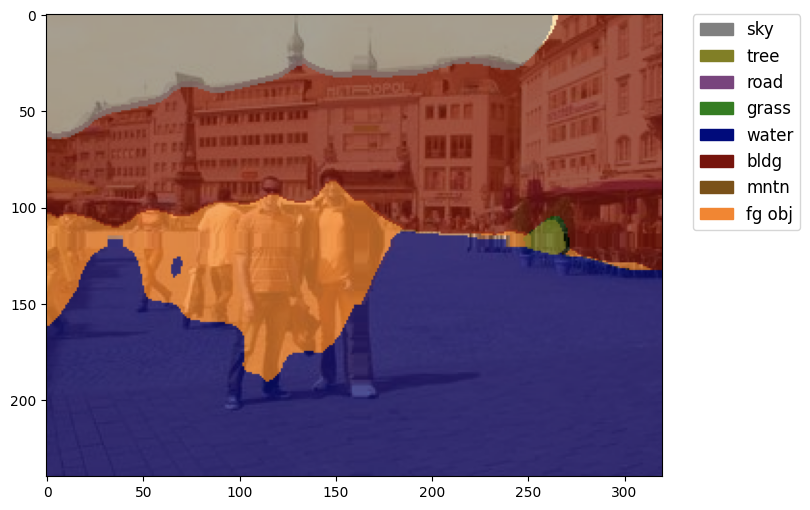

In [31]:
from mmseg.apis import init_model, inference_model, show_result_pyplot

# Init the model from the config and the checkpoint
checkpoint_path = './work_dirs/checkpoints/iter_500.pth'
model = init_model(cfg, checkpoint_path, 'cuda:0')

img = mmcv.imread('iccv09Data/images/0000047.jpg')
result = inference_model(model, img)
plt.figure(figsize=(8, 6))
vis_result = show_result_pyplot(model, img, result,opacity=0.7)
plt.imshow(vis_result)
# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(8)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')
plt.show()